## Setup Github

Import the github repository and move it into the local directory (also remove the defult samples directoy if it exists)

In [2]:
from getpass import getpass
import os

user = "mattiaguerri"
password = getpass('github password')
os.environ['GITHUB_AUTH'] = user + ':' + password

# clone the repo
!git clone https://$GITHUB_AUTH@github.com/msc-acse/acse-8-miniproject-softmax.git repo
    
# move the repo up one
!mv repo/* .
!mv repo/.git .

# delete un needed stuff
!rm -r repo
!rm -r sample_data/

github password··········
Cloning into 'repo'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 466 (delta 6), reused 18 (delta 2), pack-reused 439
Receiving objects: 100% (466/466), 78.41 MiB | 26.84 MiB/s, done.
Resolving deltas: 100% (251/251), done.
mv: cannot move 'repo/data' to './data': Directory not empty
mv: cannot move 'repo/models' to './models': Directory not empty
mv: cannot move 'repo/spec' to './spec': Directory not empty
mv: cannot move 'repo/training' to './training': Directory not empty
mv: cannot move 'repo/.git' to './.git': Directory not empty
rm: cannot remove 'sample_data/': No such file or directory


### Github Commands

In [3]:
!git checkout mattia
# !git reset --hard
!git pull origin mattia
!ls -l
!git log

D	.gitignore
Branch 'mattia' set up to track remote branch 'mattia' from 'origin'.
Switched to a new branch 'mattia'
From https://github.com/msc-acse/acse-8-miniproject-softmax
 * branch            mattia     -> FETCH_HEAD
Already up to date.
total 36
drwxr-xr-x 2 root root 4096 May 22 14:08 data
drwxr-xr-x 6 root root 4096 May 22 14:40 models
drwxr-xr-x 2 root root 4096 May 22 14:13 __pycache__
-rw-r--r-- 1 root root  771 May 22 14:40 README.md
drwxr-xr-x 2 root root 4096 May 22 14:08 spec
-rw-r--r-- 1 root root 9714 May 22 14:40 tools.py
drwxr-xr-x 3 root root 4096 May 22 14:40 training
commit 267ce3540116e01ba79dc71e66fedba2cb9a5d8a (HEAD -> mattia, origin/mattia)
Author: mattiaguerri <mattguerri1@gmail.com>
Date:   Wed May 22 14:19:18 2019 +0100

    add WD log

commit caa47ba3cfcbc7168cc8bcd7ca267005ed657497
Merge: eca6f00 11255be
Author: mattiaguerri <mattguerri1@gmail.com>
Date:   Wed May 22 09:26:23 2019 +0100

    Merge branch 'master' into mattia

commit 11255be6ac67e1775d7bd

## Setup Imports

Ipython imports and functions

In [4]:
# ipython setup
!pip install pycm livelossplot
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


Module imports

In [0]:
# imports
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, RandomCrop, ToPILImage, Pad, RandomAffine, ColorJitter

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# imports from github
from tools import *

Check runtime device

In [6]:
# check running device
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


Mount google drive if wanted

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

## Load Data

In [0]:
train_feat = np.load("/content/data/kmnist-train-imgs.npy")
train_targ = np.load("/content/data/kmnist-train-labels.npy")
test_feat = np.load("/content/data/kmnist-test-imgs.npy")

In [8]:
# check what the data looks like
for data, data_name in zip([train_targ, test_feat, train_feat], 
                           ["train_targ", "test_feat", "train_feat"]):
    
    print(data_name)
    
    for name, code in zip(["shape", "mean", "std", "max", "min", "type", "cuda"],
                          ["data.shape", "data.mean()", "data.std()", 
                           "data.max()", "data.min()", "data.dtype"]):
        try:
            exec("print('\t', name, '\t:\t', " + code + ")")
        except:
            print("\t", name, "\t:\t undefined")

train_targ
	 shape 	:	 (60000,)
	 mean 	:	 4.5
	 std 	:	 2.8722813232690143
	 max 	:	 9
	 min 	:	 0
	 type 	:	 uint8
test_feat
	 shape 	:	 (10000, 28, 28)
	 mean 	:	 47.06204145408163
	 std 	:	 87.1110021912918
	 max 	:	 255
	 min 	:	 0
	 type 	:	 uint8
train_feat
	 shape 	:	 (60000, 28, 28)
	 mean 	:	 48.89934757653061
	 std 	:	 88.82742173832395
	 max 	:	 255
	 min 	:	 0
	 type 	:	 uint8


Now set our parameters

In [0]:
# Other Hyperparameters
Seed = 42
Learning_Rate = 1e-2
Momentum = 0.5
Batch_Size = 64
Test_Batch_Size = 1000
Number_of_Epochs = 30

## Data pre-processing

Define the data set creation function with the transformations.

In [0]:
# Set a heavy augmentation in the transform.

def create_dataset(train, targ, t_id, v_id):
    
    # make trgets torch type and shape
    targ = torch.from_numpy(targ)
    targ = targ.long()
    # (features are changed in the transofrmations)
    
    # seperate the data
    t_feat = train[t_id]
    v_feat = train[v_id]
    t_targ = targ[t_id]
    v_targ = targ[v_id]
    
    # find mean and std
    mean, std = np.mean(t_feat)/255., np.std(t_feat)/255.
    print("avg:", mean, "std:", std)
    
    # includes data augmentation
    train_transform = Compose([
        ToPILImage(),
        RandomCrop(24),
        Pad(2),
        RandomRotation(25),
        RandomAffine(0, translate=(0.1, 0.1), scale=None, shear=15, resample=False, fillcolor=0),
        ColorJitter(brightness=0.5, contrast=0.5, saturation=0, hue=0),
        ToTensor(),
        Normalize(mean=[mean], std=[std]),
        ])

    # only want to normalize here
    validation_test_transform = Compose([
        ToTensor(),
        Normalize(mean=[mean], std=[std]),
        ])
    
    # create the custom datasets
    train_set = CustomImageTensorDataset(t_feat, t_targ, transform=train_transform)
    valid_set = CustomImageTensorDataset(v_feat, v_targ, transform=validation_test_transform)

    return train_set, valid_set

Create the indicies for the data split

In [11]:
# do the split
n_folds = 10
shuffler =  StratifiedKFold(n_splits=n_folds, random_state=42, shuffle=True)
shuffler = shuffler.split(train_feat, train_targ)

# get the indices
indices = np.array(list(shuffler))
print(indices.shape)
print([i.shape for i in indices.flatten()])

(10, 2)
[(54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,)]


Divide data into n_fold sets

In [12]:
data_loders = []
for t_index, v_index in indices[:2]:
    t_set, v_set = create_dataset(train_feat, train_targ, t_index, v_index)
    data_loders.append([ DataLoader(t_set, batch_size=Batch_Size, shuffle=True),
                         DataLoader(v_set, batch_size=Test_Batch_Size, shuffle=False)])
    
data_loders = np.array(data_loders)
data_loders.shape

avg: 0.19193742228372832 std: 0.3484717402643013
avg: 0.1917338998562388 std: 0.34832169306624683


(2, 2)

Look at the data to check it is all still good

Loaded Feature Shape: torch.Size([64, 1, 28, 28])
Loaded Target Shape: torch.Size([64])
batch mean: tensor(-0.1266)
batch std: tensor(0.7958)


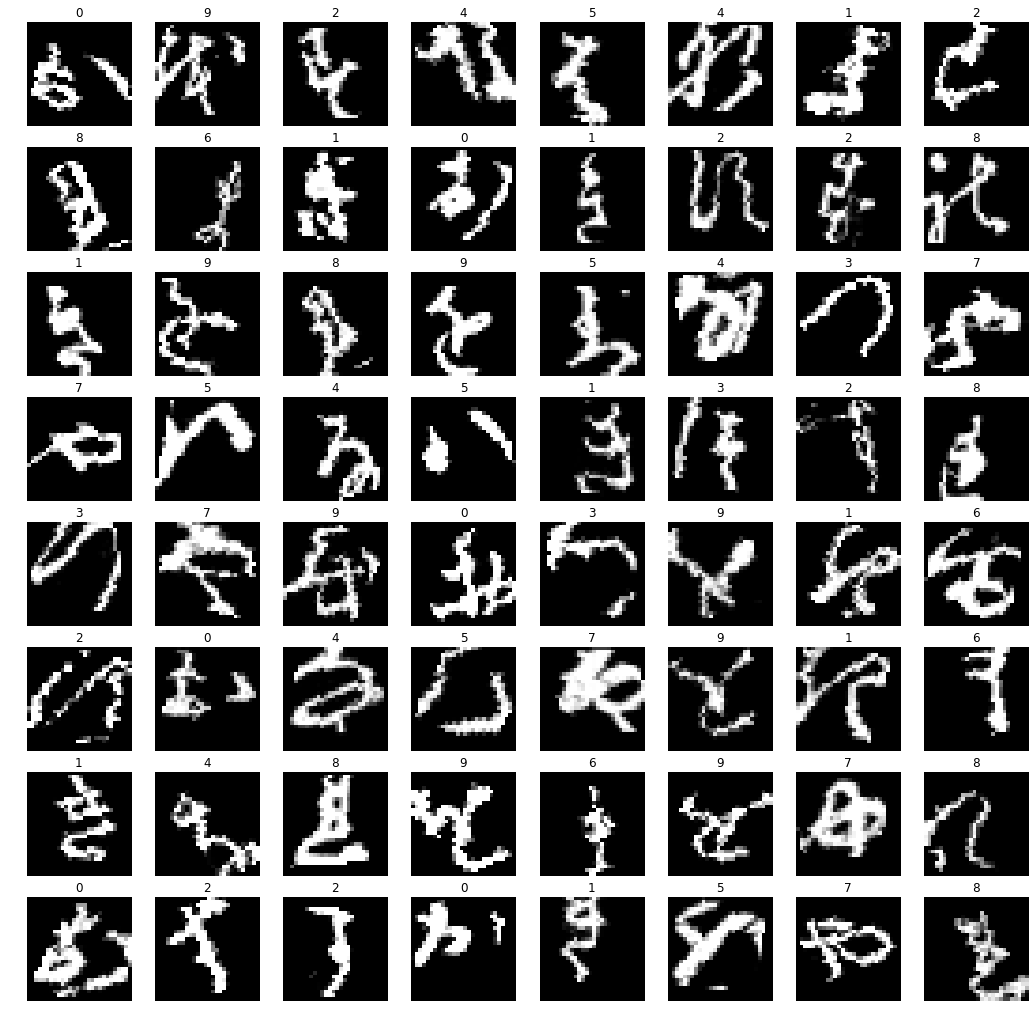

In [13]:
train_loader = data_loders[0, 0]
for X, y in train_loader:
    
    print("Loaded Feature Shape:", X.size())
    print("Loaded Target Shape:", y.size())
    print("batch mean:", X.mean())
    print("batch std:", X.std())
    
    fig, axs = plt.subplots(8, 8, figsize=[18, 18])
    
    for img, lab, ax in zip(X, y, axs.flatten()):
        ax.imshow(img[0], cmap='gray')
        ax.axis("off")
        ax.set(title=str(lab.item()))
    break

What about the standard deviation and mean. Here I manually do the transformation on each sample and look at the transformed data mean, std and shape.

In [14]:
norm = data_loders[0, 1].dataset.transform
manual = [norm(t) for t in train_feat]
manual = torch.stack(manual)
manual.mean(), manual.std(), manual.size()

(tensor(-0.0005), tensor(0.9996), torch.Size([60000, 1, 28, 28]))

## Define the Network

In [0]:
# AlexNet_half (Dropout)
class AlexNet_half_drop_batch(nn.Module):
    """
    Neural Network inspired on Alexnet, with a reduced number of parameters (989410).
    """

    def __init__(self, bias=True):
        "setup the neural network"
        
        # initalise
        super(AlexNet_half_drop_batch, self).__init__()

        # create the activation function
        act = nn.ReLU()
        
        self.convolutional = nn.Sequential(
            nn.Conv2d(1, 24, padding=1, kernel_size=4, stride=1, bias=bias), act,
            nn.BatchNorm2d(24),
            nn.MaxPool2d(kernel_size=1, stride=1), act,
            nn.Conv2d(24, 64, padding=2, kernel_size=5, stride=1, bias=bias), act,
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2), act,
            nn.Conv2d(64, 96, padding=2, kernel_size=5, stride=1, bias=bias), act,
            nn.Conv2d(96, 96, padding=1, kernel_size=3, stride=1, bias=bias), act,
            nn.Conv2d(96, 64, padding=1, kernel_size=3, stride=1, bias=bias), act,
            nn.MaxPool2d(kernel_size=3, stride=2), act)
        
        self.full_connected = nn.Sequential(
            nn.Dropout(),
            nn.Linear(2304, 256, bias=bias), act,
            nn.Dropout(),
            nn.Linear(256, 256, bias=bias), act,
            nn.Linear(256, 10, bias=bias)
        )

    def flatten(self, T):
        "flatten the image for the fully connected layers"
        return T.view(-1, T.size(1)*T.size(2)*T.size(3))
        
        
    def forward(self, x):
        "Pass through the neural network"
        x = self.convolutional(x)
        x = self.flatten(x)
        x = self.full_connected(x)
        return x

Sanity check

In [16]:
x = torch.randn((1, 1, 28, 28))
test_model = AlexNet_half_drop_batch()

y = test_model(x)
print("Output (pre-softmax):\n", y.detach().numpy())

Output (pre-softmax):
 [[-0.01291101  0.02631927  0.02887173 -0.05052977  0.0207531   0.02284471
   0.05974646 -0.02641122  0.07877634 -0.04509202]]


## Model Training

In [17]:
# setup
set_seed(Seed)
model = AlexNet_half_drop_batch().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=Learning_Rate, momentum=Momentum)
criterion = nn.CrossEntropyLoss()
train_loader, validate_loader = data_loders[0]

wrapper = train_wrapper(model, optimizer, train_loader, validate_loader, 
                        criterion=criterion, device=device)
wrapper.num_model_params()

Number of model Parameters:  989586


989586

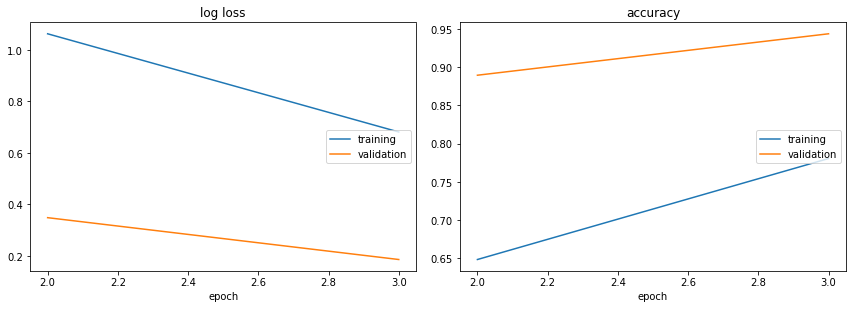

log loss:
training   (min:    0.682, max:    2.003, cur:    0.682)
validation (min:    0.186, max:    0.879, cur:    0.186)

accuracy:
training   (min:    0.260, max:    0.781, cur:    0.781)
validation (min:    0.713, max:    0.944, cur:    0.944)


In [0]:
wrapper.train_model(5)
wrapper.save_model("overnight_5.pth", "/")

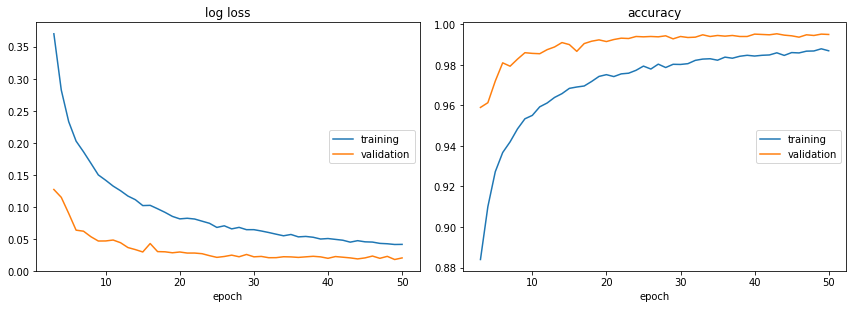

log loss:
training   (min:    0.042, max:    1.594, cur:    0.042)
validation (min:    0.018, max:    0.437, cur:    0.021)

accuracy:
training   (min:    0.424, max:    0.988, cur:    0.987)
validation (min:    0.864, max:    0.995, cur:    0.995)
Training Finished
saved to /content/gdrive/My Drive/models/overnight_50.pth


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type AlexNet_half_drop_batch. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
wrapper.train_model(45)
wrapper.save_model("overnight_50.pth")

In [1]:
load_dict = torch.load(("overnight_50.pth")
wrapper.train_model(50)
wrapper.save_model("overnight_100.pth")

NameError: ignored

In [0]:
wrapper.train_model(50)
wrapper.save_model("overnight_150.pth")

In [0]:
wrapper.train_model(50)
wrapper.save_model("overnight_200.pth")

## Load Models again

In [0]:
epoch_100 = torch.load("/content/gdrive/My Drive/models/overnight_100.pth")
epoch_150 = torch.load("/content/gdrive/My Drive/models/overnight_150.pth")
epoch_200 = torch.load("/content/gdrive/My Drive/models/overnight_100.pth")

In [0]:
valid_loader = data_loders[0, 1]
valid_loader.dataset.transform = epoch_150["transform"]
wrapper_150 = train_wrapper(epoch_150["model"], None, None, valid_loader, device=device)
wrapper_150.validate()

(tensor(0.0197, device='cuda:0'), 0.9963333333333333)

In [0]:
cfm = wrapper_150.confusion_matrix()
print(cfm)

(6000,) (6000,) torch.Size([1000]) torch.Size([1000])
Predict   0         1         2         3         4         5         6         7         8         9         
Actual
0         600       0         0         0         0         0         0         0         0         0         

1         0         599       0         0         0         1         0         0         0         0         

2         0         0         598       0         1         0         0         1         0         0         

3         0         0         0         600       0         0         0         0         0         0         

4         3         0         0         0         595       0         0         0         1         1         

5         0         0         0         1         0         599       0         0         0         0         

6         0         1         2         0         0         0         596       0         1         0         

7         1         0         0         1   